In [1]:
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p) - np.log(1 - p)


In [3]:
time = np.linspace(0,100,100)
y = np.sin(2*np.pi*time) + np.random.normal(0, .05, size=time.size)
y[97:] = None
y[10:12] = None




with pm.Model() as model:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    alpha = pm.Uniform('alpha', 0,1)
    nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)
    μ = pm.GaussianRandomWalk('μ',
                              sigma=σ_ϵ * (1.0 - alpha),
                              shape=len(y))

    level = pm.StudentT('level',
                      mu=μ,
                        nu=nu_0,
                      sigma=σ_ϵ * alpha,
                      observed=y
                    )

    trace = pm.sample(2000,
                      tune=3000,
                      target_accept=.95,
                      return_inferencedata=True)


    ppc = pm.sample_posterior_predictive(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in level contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [level_missing, μ, nu_0, alpha, σ_ϵ]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 84 seconds.
The acceptance probability does not

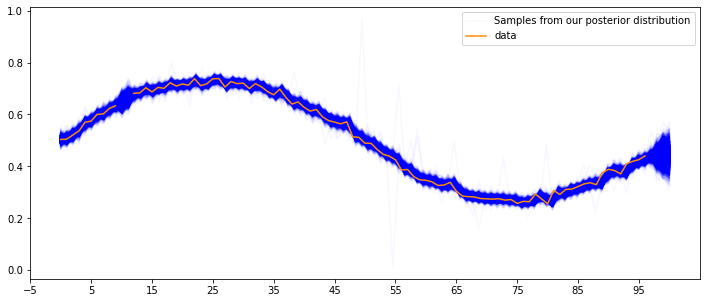

In [4]:
with model:
    _, ax = plt.subplots(1,1,figsize=(12,5))
    predictions = inv_logit(ppc['level'])
    ax.plot(time, predictions.T[:,1:], alpha=0.03, color='b', label='_')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))


    ax.plot(time,predictions.T[:,1],alpha=0.03, color='b', label='Samples from our posterior distribution')
    ax.plot(inv_logit(y), color='darkorange', label='data')
    ax.legend()
    az.summary(trace)

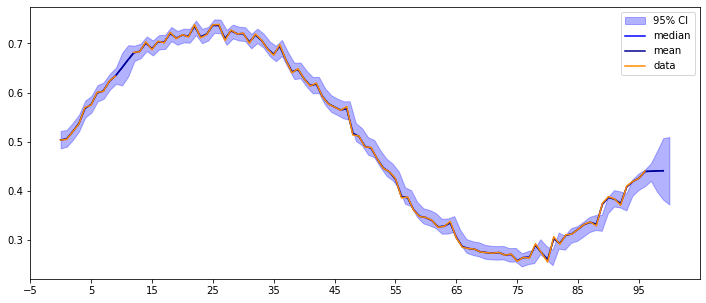

In [5]:

predictions = inv_logit(ppc['level'])
CI = np.percentile(predictions, axis=0, q=[2.5, 50, 97.5])

mean = np.mean(predictions, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(time,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(inv_logit(y), color='darkorange', label='data')
ax.legend();

In [6]:
y

array([ 0.01414344,  0.01981899,  0.08336087,  0.14553088,  0.28110209,
        0.30035894,  0.40824637,  0.41484703,  0.50361615,  0.54734003,
               nan,         nan,  0.7615346 ,  0.76869751,  0.86310862,
        0.78707527,  0.86862552,  0.85253586,  0.95705617,  0.89391247,
        0.93310768,  0.91017931,  1.03628237,  0.90254684,  0.93404238,
        1.03472718,  1.03859586,  0.8760811 ,  0.98086313,  0.93938177,
        0.94971113,  0.84829703,  0.94015787,  0.87964167,  0.79203502,
        0.7352738 ,  0.83701104,  0.69074839,  0.57592307,  0.61236662,
        0.52284728,  0.46101341,  0.48745681,  0.37056178,  0.30892061,
        0.28428207,  0.25761544,  0.28882236,  0.05544555,  0.04686874,
       -0.04229128, -0.04554582, -0.13982039, -0.21602882, -0.24355212,
       -0.30029349, -0.46447714, -0.45617151, -0.57271191, -0.62886374,
       -0.63561125, -0.66151975, -0.72551273, -0.71700903, -0.67068205,
       -0.82506278, -0.91761251, -0.92914061, -0.93539603, -0.96

In [85]:
days = np.arange(80)
h = .75
state_polls = np.clip(np.random.normal(h, .01, size=days.size), a_min=0.01, a_max=.99)
national_polls = np.clip(np.random.normal((h-.01)- np.exp(-np.arange(80)/10), .03, size=days.size), a_min=0.01, a_max=.99)
state_observed = logit(state_polls)
state_observed[::5] = None
state_observed[1::5] = None
state_observed[2::5] = None
state_observed[-10:] = None
national_observed = logit(national_polls)
national_observed[::10] = None
national_observed[1::10] = None
national_observed[2::10] = None
national_observed[3::10] = None
national_observed[-10:] = None
# national_observed = np.zeros_like(days)

In [91]:

with pm.Model() as linzer_model:
    σ_δ = pm.HalfNormal('σ_δ', 1)
    σ_β = pm.HalfNormal('σ_β', 1)
    # τ = pm.Constant('tau', c=20)
    τ = pm.Uniform('τ', lower=10,upper=20)  # This is up to the discretion of the analyst
    # β_J = pm.Normal('β_J', mu=pm.logit(h), tau=τ)
    β_J = pm.Normal.dist(mu=pm.logit(h), tau=τ)
    μ_β = pm.GaussianRandomWalk('μ_β',
                                sigma=σ_β,
                                init=β_J,
                                shape=len(days)
                                )
    μ_δ = pm.GaussianRandomWalk('μ_δ',
                                sigma=σ_δ,
                                shape=len(days)
                                )
    β = pm.Normal('β', mu=μ_β, sigma=σ_β, observed=state_observed)
    δ = pm.Normal('δ', mu=μ_δ, sigma=σ_δ, observed=national_observed)
    π = pm.invlogit((β + δ)/2)
    y_k = pm.Binomial('y_k', p=π[-1], n=1000)

    trace = pm.sample(200,
                      # tune=3000,
                      return_inferencedata=True)
    ppc = pm.sample_posterior_predictive(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in β contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in δ contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [δ_missing, β_missing, μ_δ, μ_β, τ, σ_β, σ_δ]
>Metropolis: [y_k]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: 

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 fo

In [58]:
inv_logit((ppc['β']+ppc['δ'])/2)[:5]

array([[0.74378861, 0.74897058, 0.72566184, 0.74131984, 0.74491524,
        0.7431103 , 0.76221985, 0.74339401, 0.73633409, 0.73342337,
        0.74055475, 0.76529931, 0.75436006, 0.74922922, 0.75798731,
        0.75796425, 0.77402552, 0.75476779, 0.7522164 , 0.76563394,
        0.74505767, 0.76460532, 0.76747967, 0.76908335, 0.75843608,
        0.76696311, 0.74567667, 0.76458368, 0.75305041, 0.74831459,
        0.71106938, 0.72247716, 0.73450428, 0.73323137, 0.71287711,
        0.72926487, 0.71621063, 0.73151582, 0.74402164, 0.72944125,
        0.73581775, 0.73277489, 0.75212876, 0.76057212, 0.76485016,
        0.75916956, 0.76622997, 0.7725622 , 0.75904639, 0.74611616,
        0.75650582, 0.73233271, 0.75682892, 0.74548517, 0.74126031,
        0.74850892, 0.73159778, 0.7471576 , 0.71090207, 0.7485324 ,
        0.74004496, 0.72519577, 0.72064386, 0.7404812 , 0.74002167,
        0.72921556, 0.7282358 , 0.74450672, 0.73447215, 0.73522752,
        0.71360926, 0.73354435, 0.74586584, 0.75

In [59]:
inv_logit(ppc['β'])[:5]

array([[0.7585687 , 0.76857577, 0.74531531, 0.75300594, 0.74642491,
        0.76294517, 0.7550548 , 0.75468584, 0.74670417, 0.74316093,
        0.73741654, 0.7385084 , 0.74236486, 0.74916626, 0.75626188,
        0.75343327, 0.76574077, 0.75853932, 0.76214225, 0.75631842,
        0.74829036, 0.75242706, 0.75188505, 0.76565934, 0.76740956,
        0.76095367, 0.76508715, 0.75969157, 0.74980629, 0.74503745,
        0.73719518, 0.73059512, 0.73403101, 0.75365443, 0.74117042,
        0.75106087, 0.74705823, 0.76235647, 0.74894931, 0.75607129,
        0.76462973, 0.77001288, 0.77329014, 0.77185354, 0.77871126,
        0.76028417, 0.76922203, 0.76049639, 0.76378734, 0.74520361,
        0.75548325, 0.75870871, 0.74681852, 0.75044874, 0.75334045,
        0.74035823, 0.75077556, 0.72661047, 0.73113695, 0.72893322,
        0.73770902, 0.73086583, 0.73983677, 0.74649715, 0.73294525,
        0.74542271, 0.74282368, 0.73917459, 0.74758676, 0.7495697 ,
        0.74501868, 0.75047122, 0.74606387, 0.74

In [60]:
inv_logit(ppc['δ'])[:5]

array([[0.72842762, 0.72829168, 0.70509185, 0.72927961, 0.74339967,
        0.72222005, 0.76923936, 0.73176715, 0.72569543, 0.72345401,
        0.74366849, 0.79012544, 0.76597284, 0.74929217, 0.75970441,
        0.76243822, 0.78210065, 0.75095669, 0.74201655, 0.77469943,
        0.74179779, 0.77636258, 0.78237782, 0.77247221, 0.74922952,
        0.77286657, 0.72523832, 0.76940643, 0.75626613, 0.75156365,
        0.68346158, 0.71421028, 0.734977  , 0.7117627 , 0.68281455,
        0.70630676, 0.68319636, 0.69825693, 0.73903096, 0.70105346,
        0.70484029, 0.69191988, 0.72968262, 0.74891432, 0.75039912,
        0.75805142, 0.76321106, 0.78419265, 0.75424091, 0.74702656,
        0.75752549, 0.7041976 , 0.76656724, 0.74045703, 0.72880153,
        0.7564879 , 0.71151133, 0.76665639, 0.68979043, 0.76716713,
        0.74236736, 0.7194521 , 0.70060803, 0.73437328, 0.74697532,
        0.71237474, 0.71313999, 0.74976674, 0.7209305 , 0.72037038,
        0.67999262, 0.71590391, 0.74566771, 0.76

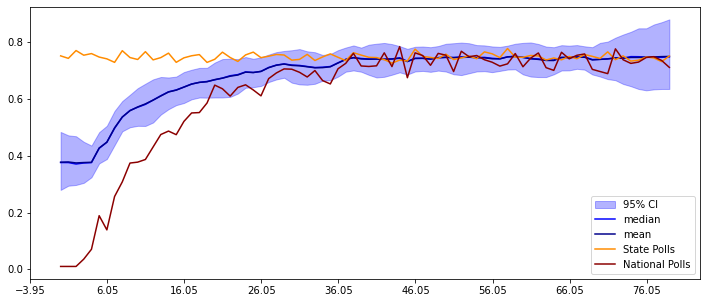

In [92]:
predictions = inv_logit((ppc['β']+ppc['δ'])/2)
CI = np.percentile(predictions, axis=0, q=[2.5, 50, 97.5])

mean = np.mean(predictions, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(days,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(state_polls, color='darkorange', label='State Polls')
ax.plot(national_polls, color='darkred', label='National Polls')
ax.legend()

array([[<AxesSubplot:title={'center':'μ_β'}>,
        <AxesSubplot:title={'center':'μ_β'}>],
       [<AxesSubplot:title={'center':'μ_δ'}>,
        <AxesSubplot:title={'center':'μ_δ'}>],
       [<AxesSubplot:title={'center':'β_missing'}>,
        <AxesSubplot:title={'center':'β_missing'}>],
       [<AxesSubplot:title={'center':'δ_missing'}>,
        <AxesSubplot:title={'center':'δ_missing'}>],
       [<AxesSubplot:title={'center':'y_k'}>,
        <AxesSubplot:title={'center':'y_k'}>],
       [<AxesSubplot:title={'center':'σ_δ'}>,
        <AxesSubplot:title={'center':'σ_δ'}>],
       [<AxesSubplot:title={'center':'σ_β'}>,
        <AxesSubplot:title={'center':'σ_β'}>],
       [<AxesSubplot:title={'center':'τ'}>,
        <AxesSubplot:title={'center':'τ'}>]], dtype=object)

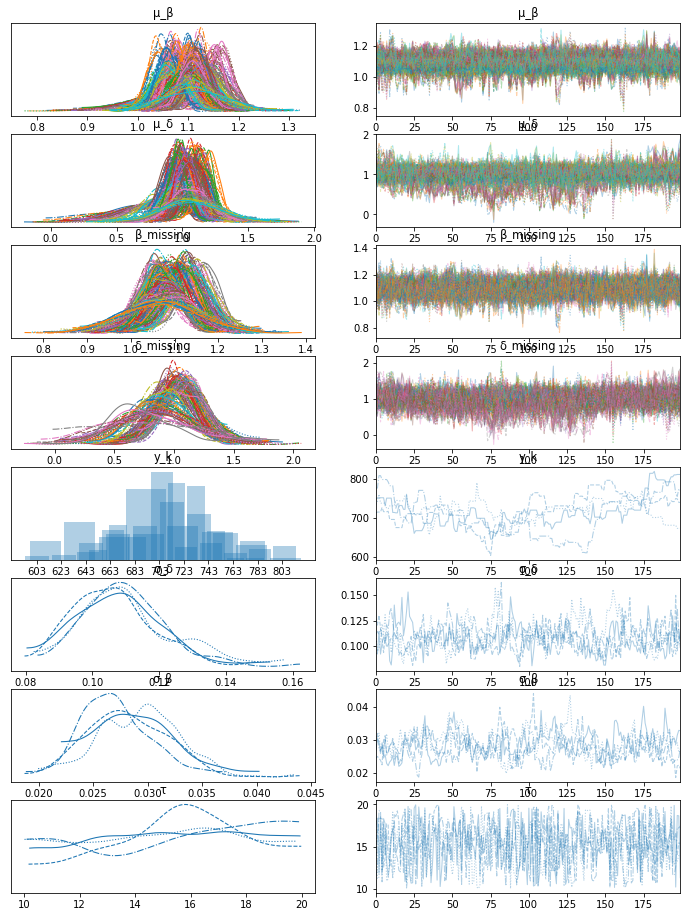

In [62]:
az.plot_trace(trace)

In [35]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_β[0],1.080,0.029,1.033,1.140,0.001,0.001,960.0,619.0,1.01
μ_β[1],1.056,0.024,1.007,1.097,0.001,0.001,824.0,558.0,1.01
μ_β[2],1.094,0.024,1.048,1.136,0.001,0.001,894.0,536.0,1.01
μ_β[3],1.082,0.024,1.038,1.124,0.001,0.001,931.0,555.0,1.00
μ_β[4],1.090,0.023,1.049,1.137,0.001,0.001,686.0,495.0,1.01
...,...,...,...,...,...,...,...,...,...
μ_δ[79],0.670,0.129,0.436,0.923,0.005,0.004,564.0,363.0,1.01
y_k,697.342,14.591,672.000,725.000,0.983,0.696,223.0,198.0,1.04
σ_δ,0.168,0.014,0.146,0.196,0.001,0.001,276.0,458.0,1.01
σ_β,0.036,0.003,0.031,0.042,0.000,0.000,217.0,361.0,1.02
